# Advent of Haystack: Day 10


In this challenge, we will evaluate our RAG pipeline using [EvaluationHarness](https://docs.haystack.deepset.ai/v2.9-unstable/docs/evaluationharness), an evaluation orchestrator that streamlines the assessment of pipeline performance, making the evaluation process simpler and more efficient.

🧪 `EvaluationHarness` is an experimental feature that will be merged into the main repository with Haystack 2.9.0. Find more info in this [GitHub discussion](https://github.com/deepset-ai/haystack-experimental/discussions/74)


## Installation

Start by installing `haystack-ai` and `datasets` packages:

In [ ]:
!pip install haystack-ai datasets

## Enter OpenAI and HF API Keys

In this challenge, you will use [meta-llama/Llama-3.2-1B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) and [meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) which are gated and requires extra steps to access through [Hugging Face Inference API](https://huggingface.co/docs/api-inference/en/index).


To access these models:
1. You need a [Hugging Face](https://huggingface.co/) account
2. You have to accept conditions in their model pages. You will get access in short time
3. Copy your HF token (https://huggingface.co/settings/tokens) and paste it below

The model page should have "**You have been granted access to this model**" text to indicate that you can use these models

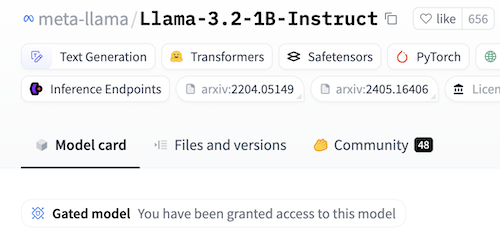

**NOTE:** To be able to use LLM-based evaluators, such as [FaithfulnessEvaluator](https://docs.haystack.deepset.ai/docs/faithfulnessevaluator), [ContextRelevanceEvaluator](https://docs.haystack.deepset.ai/docs/contextrelevanceevaluator), you need an `OPENAI_API_KEY`. Feel free to skip this key if you don't want to use these metrics.

In [3]:
%load_ext dotenv
%dotenv
import os

os.environ["HF_API_TOKEN"] = os.getenv("HUGGINGFACE_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Prepare the Dataset

Download the [HotpotQA dataset](https://huggingface.co/datasets/hotpotqa/hotpot_qa) from Hugging Face:

In [4]:
from datasets import load_dataset

data = load_dataset('hotpotqa/hotpot_qa', 'distractor', split='train[:50]', trust_remote_code=True)

/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 7405/7405 [00:00<00:00, 8391.01 examples/s] 


Check one of the entries to understand the data structure. In Hotpot QA, each entry includes a question, a ground-truth answer, context sentences and titles.

In [5]:
data[4]

{'id': '5a84dd955542997b5ce3ff79',
 'question': 'Cadmium Chloride is slightly soluble in this chemical, it is also called what?',
 'answer': 'alcohol',
 'type': 'bridge',
 'level': 'medium',
 'supporting_facts': {'title': ['Cadmium chloride', 'Ethanol'],
  'sent_id': [1, 0]},
 'context': {'title': ['Cadmium chloride',
   'Water blue',
   'Diflucortolone valerate',
   'Heptanoic acid',
   'Magnesium chloride',
   'Ethanol',
   'Tributyltin oxide',
   'Benzamide',
   'Gold(III) chloride',
   'Chloride'],
  'sentences': [['Cadmium chloride is a white crystalline compound of cadmium and chlorine, with the formula CdCl.',
    ' It is a hygroscopic solid that is highly soluble in water and slightly soluble in alcohol.',
    ' Although it is considered to be ionic, it has considerable covalent character to its bonding.',
    ' The crystal structure of cadmium chloride (described below), composed of two-dimensional layers of ions, is a reference for describing other crystal structures.',
    '

Convert the datapoints into Haystack Documents to use in indexing, querying and evaluation. Each sentence will become a Haystack Document and store some information as metadata such as "rank" and "ground_truth_answer".

In [6]:
from haystack.dataclasses.document import Document

def convert_hotpot_to_docs(data):
    question = []
    true_answer = []
    doc_chunks = []

    for item in data:

        question.append(item['question'])
        true_answer.append(item['answer'])

        # Documents
        assert len(item['context']["title"]) == len(item['context']["sentences"])
        context_dict = {item['context']["title"][i]: item['context']["sentences"][i] for i in range(len(item['context']["title"]))}

        # Add default rank (irrelevant docs will have the rank of 1000)
        for k, v in context_dict.items():
            context_dict[k] = [(vv, 1000, item["id"], item["question"], item["answer"]) for vv in v if vv.strip()] # remove empty contents

        # Add True rank (irrelevant docs will have the the true rank)
        assert len(item['supporting_facts']["title"]) == len(item['supporting_facts']["sent_id"])

        for i in range(len(item['supporting_facts']["title"])):

            k = item['supporting_facts']["title"][i] # Key
            v_pos = item['supporting_facts']["sent_id"][1] # Value
            rank = i

            if v_pos < len(context_dict[k]):
                context_dict[k][v_pos] = (context_dict[k][v_pos][0], rank, context_dict[k][v_pos][2], context_dict[k][v_pos][3], context_dict[k][v_pos][4])

        nested_list = [v for k, v in context_dict.items()]
        chunks = [x for xs in nested_list for x in xs]

        # Sort by rank (for MRR)
        sorted_chunks = sorted(chunks, key=lambda tup: tup[1])

        # Create Haystack Documents
        doc_chunks.append([Document(content=tup[0], meta={"rank":tup[1], "data_id":tup[2],  "question": tup[3], "ground_truth_answer": tup[4]}) for tup in sorted_chunks])

    return question, true_answer, doc_chunks

In [7]:
questions, ground_truth_answers, doc_chunks = convert_hotpot_to_docs(data)

In [8]:
documents = [doc for chunk in doc_chunks for doc in chunk]

A relevant document example after processing:

```python
Document(
  id=414..ba,
  content: "Arthur's Magazine (1844–1846) was an American literary periodical published in Philadelphia in the 1...",
  meta: {'rank': 0, 'data_id': '5a87ab905542996e4f3088c1', 'question': "Which magazine was started first Arthur's Magazine or First for Women?", 'ground_truth_answer': "Arthur's Magazine"}
)
```

### Create a ground truth dataset

Then, trim the irrelevant documents for the `ground_truth_documents` dataset

In [9]:
ground_truth_documents = []

for chunk in doc_chunks:
  new_list = []
  for doc in chunk:
    if doc.meta["rank"] < 1000: # if a document is relevant
      new_list.append(doc)
  ground_truth_documents.append(new_list)

## Indexing Documents

Create a pipeline and index documents to [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore). For document embeddings, use the[`BAAI/bge-m3`](https://huggingface.co/BAAI/bge-m3) model through [HuggingFaceAPIDocumentEmbedder](https://docs.haystack.deepset.ai/docs/huggingfaceapidocumentembedder).

⏳ This step might take around 3 minutes

In [11]:
from haystack import Pipeline
from haystack.components.embedders import HuggingFaceAPIDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

document_store = InMemoryDocumentStore()
document_embedder = HuggingFaceAPIDocumentEmbedder(api_type="serverless_inference_api",
                                              api_params={"model": "BAAI/bge-m3"})
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.SKIP)

indexing = Pipeline()
indexing.add_component(instance=document_embedder, name="document_embedder")
indexing.add_component(instance=document_writer, name="document_writer")

indexing.connect("document_embedder.documents", "document_writer.documents")

indexing.run({"document_embedder": {"documents": documents}})

Calculating embeddings: 100%|██████████| 65/65 [00:16<00:00,  3.95it/s]
ID '5777cc6d0bcf6ca28183bf58a82c6aa103fa068c9d206ba71db5e814ebaf00a0' already exists
ID '36d860a54390cde995046b4581e3824fe660c632d0a474dd11707f446f12b9be' already exists


{'document_writer': {'documents_written': 2064}}

## RAG Pipeline
Create a basic RAG pipeline using [meta-llama/Llama-3.2-1B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) through [HuggingFaceAPIGenerator](https://docs.haystack.deepset.ai/docs/huggingfaceapigenerator)


In [12]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import HuggingFaceAPITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.generators import HuggingFaceAPIGenerator

generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={"model": "meta-llama/Llama-3.2-1B-Instruct"},
)

template = """
<|start_header_id|>assistant<|end_header_id|>
Answer the following question based on the given context information only.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

rag_pipeline = Pipeline()
rag_pipeline.add_component(
    "query_embedder",
    HuggingFaceAPITextEmbedder(api_type="serverless_inference_api",
                                              api_params={"model": "BAAI/bge-m3"}),
)
rag_pipeline.add_component("retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
rag_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipeline.add_component("generator", generator)

rag_pipeline.connect("query_embedder", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - query_embedder: HuggingFaceAPITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceAPIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

Test your pipeline before starting evaluation

In [13]:
question = "Cadmium Chloride is slightly soluble in this chemical, it is also called what?"

rag_pipeline.run({
    "query_embedder": {"text": question},
    "prompt_builder": {"question": question}
})

/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/huggingface_hub/inference/_client.py:2232: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


{'generator': {'replies': [' Organic solvent'],
  'meta': [{'model': 'meta-llama/Llama-3.2-1B-Instruct',
    'finish_reason': 'eos_token',
    'usage': {'completion_tokens': 3}}]}}

## Task: Evaluate the RAG Pipeline with EvaluationHarness

`EvaluationHarness` executes a pipeline with a given set of inputs and evaluates its outputs with an evaluation pipeline using Haystack's built-in [Evaluators](https://docs.haystack.deepset.ai/docs/evaluators). This means you don't need to create a separate evaluation pipeline.

[RAGEvaluationHarness](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragevaluationharness) class, derived from `EvaluationHarness`, simplifies the evaluation process specifically for RAG pipelines. It comes with a predefined set of evaluation metrics, detailed in the [RAGEvaluationMetric](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragevaluationmetric) enum, and basic RAG architecture examples, listed in the [DefaultRAGArchitecture](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#defaultragarchitecture) enum.

Your task is to calculate Semantic Answer Similarity, Faithfulness, Context Relevance, Document Recall (Single hit) and Document MRR scores using `RAGEvaluationHarness`.

In [15]:
from haystack_experimental.evaluation.harness.rag import (
    DefaultRAGArchitecture,
    RAGEvaluationHarness,
    RAGEvaluationMetric,
    RAGEvaluationInput
)

pipeline_eval_harness = RAGEvaluationHarness(
    rag_pipeline=rag_pipeline,
    rag_components=DefaultRAGArchitecture.GENERATION_WITH_EMBEDDING_RETRIEVAL,
    metrics={
        RAGEvaluationMetric.SEMANTIC_ANSWER_SIMILARITY,
        RAGEvaluationMetric.FAITHFULNESS,
        RAGEvaluationMetric.CONTEXT_RELEVANCE,
        RAGEvaluationMetric.DOCUMENT_RECALL_SINGLE_HIT,
        RAGEvaluationMetric.DOCUMENT_MRR
    }
)

eval_harness_input = RAGEvaluationInput(
    queries=questions,
    ground_truth_answers=ground_truth_answers,
    ground_truth_documents=ground_truth_documents,
    rag_pipeline_inputs={
        "prompt_builder": {"question": questions}
    },
)

harness_eval_run = pipeline_eval_harness.run(inputs=eval_harness_input, run_name="rag_eval")


Executing RAG pipeline...


  0%|          | 0/50 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/huggingface_hub/inference/_client.py:2232: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(
100%|██████████| 50/50 [01:20<00:00,  1.60s/it]
/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/transformers/models/auto/configuration_auto.py:1006: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Executing evaluation pipeline...


/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/sentence_transformers/SentenceTransformer.py:195: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(
100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


### Create a Score Report

Score report calculates the aggregated score for each metric across all questions

In [16]:
harness_eval_run.results.score_report()

,metrics,score
0,metric_context_relevance,0.880000
1,metric_doc_recall_single,0.760000
2,metric_doc_mrr,0.636667
3,metric_faithfulness,0.610000
4,metric_sas,0.507267


### Increase `top_k`

Override the `top_k` value of your retriever and compare the results to the original pipeline evaluation results. Don't forget to create the score report.

💡 Expect to see an increase in "recall"

**HINT:** Use [RAGEvaluationOverrides](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragevaluationoverrides) instead of building a new pipeline from scratch

In [17]:
from haystack_experimental.evaluation.harness.rag import RAGEvaluationOverrides

overrides = RAGEvaluationOverrides(rag_pipeline={"retriever": {"top_k": 10}})

harness_eval_run_topk = pipeline_eval_harness.run(inputs=eval_harness_input, run_name="topk_10", overrides=overrides)

Executing RAG pipeline...


  0%|          | 0/50 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/huggingface_hub/inference/_client.py:2232: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(
100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Executing evaluation pipeline...


100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


In [18]:
harness_eval_run_topk.results.score_report()

,metrics,score
0,metric_context_relevance,0.920000
1,metric_doc_recall_single,0.880000
2,metric_doc_mrr,0.654079
3,metric_faithfulness,0.646667
4,metric_sas,0.598425


### Change the Generative Model

Override the RAG pipeline, use [meta-llama/Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) as the generative model in the RAG pipeline and see if it improves SAS and faithfulness.

In [19]:
overrides = RAGEvaluationOverrides(rag_pipeline={"generator": {"api_params": {"model": "meta-llama/Llama-3.2-3B-Instruct"}}})

harness_eval_run_3b = pipeline_eval_harness.run(inputs=eval_harness_input, run_name="llama_3.2_3b", overrides=overrides)

Executing RAG pipeline...


  0%|          | 0/50 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/huggingface_hub/inference/_client.py:2232: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(
100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Executing evaluation pipeline...


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


In [20]:
harness_eval_run_3b.results.score_report()

,metrics,score
0,metric_context_relevance,0.880000
1,metric_doc_recall_single,0.760000
2,metric_doc_mrr,0.636667
3,metric_faithfulness,0.593333
4,metric_sas,0.602177


## ⭐️ Bonus: Evaluate a Hybrid Retrieval Pipeline ⭐️

Add [InMemoryBM25Retriever](https://docs.haystack.deepset.ai/docs/inmemorybm25retriever) and [DocumentJoiner](https://docs.haystack.deepset.ai/docs/documentjoiner) to create a hybrid retrieval pipeline.


In [22]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import HuggingFaceAPITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever, InMemoryBM25Retriever
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.components.joiners import DocumentJoiner

generator = HuggingFaceAPIGenerator(
    api_type="serverless_inference_api",
    api_params={"model": "meta-llama/Llama-3.2-1B-Instruct"},
)

template = """
<|start_header_id|>assistant<|end_header_id|>
Answer the following question based on the given context information only.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

hybrid_pipeline = Pipeline()
hybrid_pipeline.add_component(
    "query_embedder",
    HuggingFaceAPITextEmbedder(api_type="serverless_inference_api",
                                              api_params={"model": "BAAI/bge-m3"}),
)
hybrid_pipeline.add_component("embedding_retriever", InMemoryEmbeddingRetriever(document_store, top_k=3))
hybrid_pipeline.add_component("bm25_retriever", InMemoryBM25Retriever(document_store, top_k=3))
hybrid_pipeline.add_component("joiner", DocumentJoiner())
hybrid_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
hybrid_pipeline.add_component("generator", generator)

hybrid_pipeline.connect("query_embedder", "embedding_retriever.query_embedding")
hybrid_pipeline.connect("embedding_retriever", "joiner")
hybrid_pipeline.connect("bm25_retriever", "joiner")
hybrid_pipeline.connect("joiner", "prompt_builder.documents")
hybrid_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - query_embedder: HuggingFaceAPITextEmbedder
  - embedding_retriever: InMemoryEmbeddingRetriever
  - bm25_retriever: InMemoryBM25Retriever
  - joiner: DocumentJoiner
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceAPIGenerator
🛤️ Connections
  - query_embedder.embedding -> embedding_retriever.query_embedding (List[float])
  - embedding_retriever.documents -> joiner.documents (List[Document])
  - bm25_retriever.documents -> joiner.documents (List[Document])
  - joiner.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

Test the pipeline

In [23]:
question = "Cadmium Chloride is slightly soluble in this chemical, it is also called what?"

hybrid_pipeline.run({
    "query_embedder": {"text": question},
    "bm25_retriever": {"query": question},
    "prompt_builder": {"question": question}
})

/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/huggingface_hub/inference/_client.py:2232: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


{'generator': {'replies': [' Cadmium chloride is slightly soluble in water, but very soluble in ethanol and ether.'],
  'meta': [{'model': 'meta-llama/Llama-3.2-1B-Instruct',
    'finish_reason': 'eos_token',
    'usage': {'completion_tokens': 18}}]}}

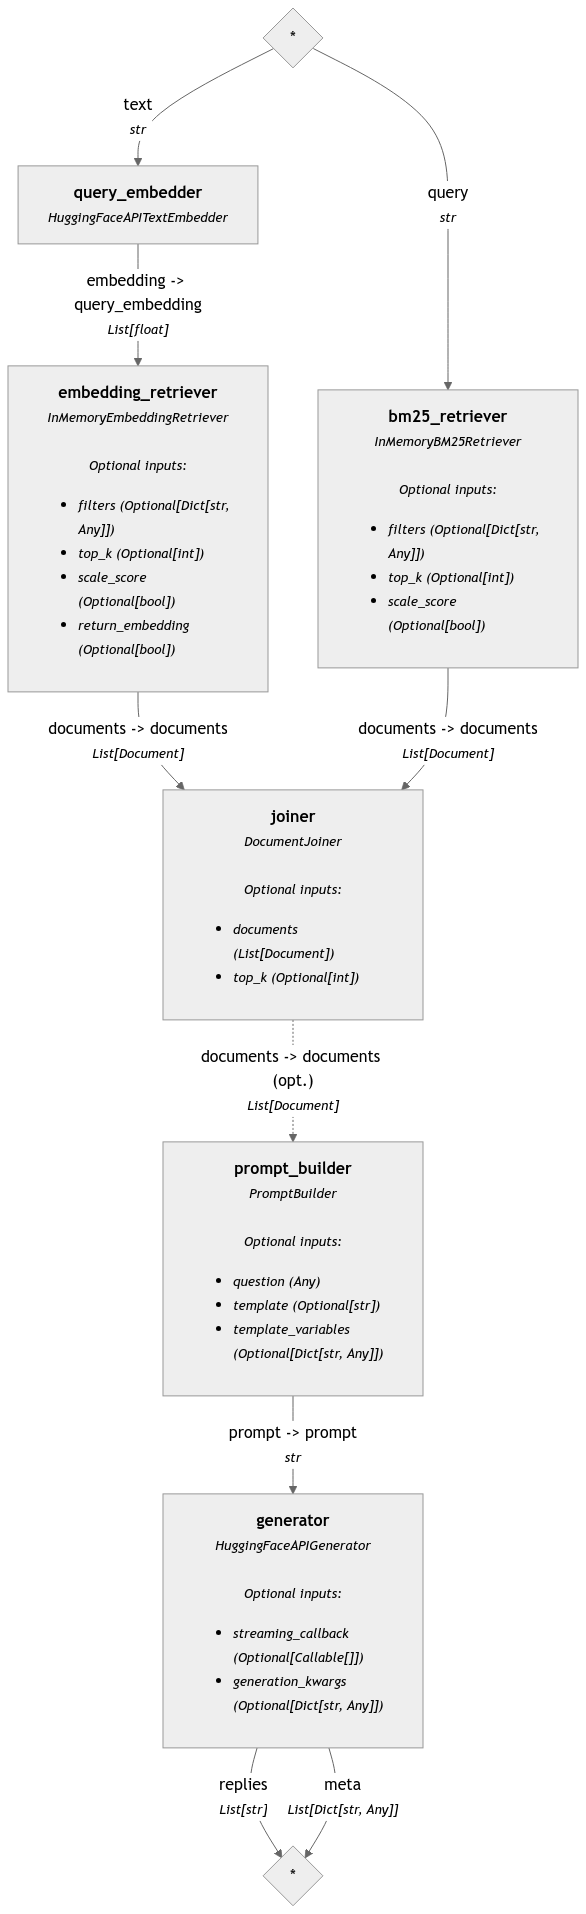

In [24]:
hybrid_pipeline.show()

### RAGEvaluationHarness for Custom Pipelines

For `RAGEvaluationHarness` to work correctly for this custom pipeline, you need to map components correctly using [RAGExpectedComponent](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragexpectedcomponent) and [RAGExpectedComponentMetadata](https://docs.haystack.deepset.ai/reference/experimental-evaluation-harness-api#ragexpectedcomponentmetadata).

You can find more details in [Evaluating RAG Pipelines with EvaluationHarness](https://haystack.deepset.ai/cookbook/rag_eval_harness#bonus-evaluationharness-for-custom-rag-pipelines)

In [32]:
from haystack_experimental.evaluation.harness.rag import (
    RAGEvaluationHarness,
    RAGEvaluationMetric,
    RAGEvaluationInput,
    RAGExpectedComponent,
    RAGExpectedComponentMetadata
)

hybrid_eval_harness = RAGEvaluationHarness(
      rag_pipeline=hybrid_pipeline,
      rag_components={
          RAGExpectedComponent.QUERY_PROCESSOR: RAGExpectedComponentMetadata(
              "query_embedder", input_mapping={"query": "text"}
          ),
          RAGExpectedComponent.QUERY_PROCESSOR: RAGExpectedComponentMetadata(
              "bm25_retriever", input_mapping={"query": "query"}
          ),
          RAGExpectedComponent.DOCUMENT_RETRIEVER: RAGExpectedComponentMetadata(
              "joiner",
              output_mapping={"retrieved_documents": "documents"},
          ),
          RAGExpectedComponent.RESPONSE_GENERATOR: RAGExpectedComponentMetadata(
              "generator", output_mapping={"replies": "replies"}
          ),
      },
      metrics={
        RAGEvaluationMetric.SEMANTIC_ANSWER_SIMILARITY,
        RAGEvaluationMetric.FAITHFULNESS,
        RAGEvaluationMetric.CONTEXT_RELEVANCE,
        RAGEvaluationMetric.DOCUMENT_RECALL_SINGLE_HIT,
        RAGEvaluationMetric.DOCUMENT_MRR
      })

eval_harness_input = RAGEvaluationInput(
    queries=questions,
    ground_truth_answers=ground_truth_answers,
    ground_truth_documents=ground_truth_documents,
    rag_pipeline_inputs={
        "query_embedder": {"text": questions},
        "prompt_builder": {"question": questions}
    },
)

harness_hybrid_eval_run = hybrid_eval_harness.run(inputs=eval_harness_input, run_name="hybrid_rag_eval")

Executing RAG pipeline...


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/transformers/models/auto/configuration_auto.py:1006: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Executing evaluation pipeline...


/opt/homebrew/Caskroom/miniforge/base/envs/advent_haystack_24/lib/python3.13/site-packages/sentence_transformers/SentenceTransformer.py:195: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v4 of SentenceTransformers.
  warnings.warn(
100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


In [33]:
harness_hybrid_eval_run.results.score_report()

,metrics,score
0,metric_context_relevance,0.960000
1,metric_doc_recall_single,0.840000
2,metric_doc_mrr,0.597667
3,metric_faithfulness,0.650833
4,metric_sas,0.533664
